In [ ]:
import mldas

In [ ]:
mldas??

In [ ]:
mldas.explore??

## Image segmentation

In [ ]:
# %%capture
from torchvision import models
fcn = models.segmentation.fcn_resnet101(weights='DEFAULT').eval()
dlab = models.segmentation.deeplabv3_resnet101(weights='DEFAULT').eval()

In [ ]:
fcn = models.segmentation.fcn_resnet101().eval()
dlab = models.segmentation.deeplabv3_resnet101().eval()

In [ ]:
import numpy
import matplotlib.pyplot as plt
labels = numpy.array([[(0, 0, 0),'background'],[(128, 0, 0), 'aeroplane'],[(0, 128, 0), 'bicycle'],[(128, 128, 0), 'bird'],
                      [(0, 0, 128), 'boat'],[(128, 0, 128), 'bottle'],[(0, 128, 128),'bus'], [(128, 128, 128),'car'],
                      [(64, 0, 0),'cat'], [(192, 0, 0),'chair'], [(64, 128, 0),'cow'],[(192, 128, 0),'dining table'],
                      [(64, 0, 128),'dog'], [(192, 0, 128),'horse'], [(64, 128, 128),'motorbike'], [(192, 128, 128),'person'],
                      [(0, 64, 0),'potted plant'], [(128, 64, 0),'sheep'], [(0, 192, 0),'sofa'], [(128, 192, 0),'train'],
                      [(0, 64, 128),'tv/monitor']], dtype=object)
label_colors = numpy.zeros((len(labels),3),dtype=numpy.uint8)
fig, ax = plt.subplots(3,7,figsize=(10,3))
for i,(color,label) in enumerate(labels):
    label_colors[i] = list(color)
    ax[i//7][i-7*(i//7)].imshow(label_colors[i].reshape(1,1,3))
    ax[i//7][i-7*(i//7)].set_title(label)
    ax[i//7][i-7*(i//7)].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import numpy
def decode_segmap(image, label_colors, nc=21):
    """
    Converting segmentation image into label mapping
    """
    r = numpy.zeros_like(image).astype(numpy.uint8)
    g = numpy.zeros_like(image).astype(numpy.uint8)
    b = numpy.zeros_like(image).astype(numpy.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = numpy.stack([r, g, b], axis=2)
    return rgb

import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
def segment(net, path, label_colors):
    img = Image.open(path)
    print(img.size, img.mode)
    img = img.convert('RGB')
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(256),
                   T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om, label_colors)
    # plt.style.use('seaborn')
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
    ax1.imshow(img)
    ax2.imshow(rgb)
    plt.tight_layout()
    plt.show()

In [ ]:
# !wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
segment(fcn, './bird.png', label_colors)
segment(dlab, './bird.png', label_colors)

In [ ]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101()
dlab = models.segmentation.deeplabv3_resnet101()

In [ ]:
import argparse
parser = argparse.ArgumentParser(description='PyTorch Unsupervised Segmentation')
# Original values: nChannel 100, maxIter 1000, minLabels 3, lr 0.1, nConv 2
parser.add_argument('--nChannel',        metavar='N',    default=100,   type=int,   help='number of channels')
parser.add_argument('--maxIter',         metavar='T',    default=100,   type=int,   help='number of maximum iterations')
parser.add_argument('--minLabels',       metavar='minL', default=3,     type=int,   help='minimum number of labels')
parser.add_argument('--lr',              metavar='LR',   default=0.1,   type=float, help='learning rate')
parser.add_argument('--nConv',           metavar='M',    default=2,     type=int,   help='number of convolutional layers')
parser.add_argument('--num_superpixels', metavar='K',    default=10000, type=int,   help='number of superpixels')
parser.add_argument('--compactness',     metavar='C',    default=100,   type=float, help='compactness of superpixels')
# args = parser.parse_args()
args = parser.parse_known_args()[0]

In [ ]:
import torch.nn as nn

class Kanezaki(nn.Module):
    def __init__(self,input_dim):
        super(Kanezaki, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, args.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(args.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(args.nConv-1):
            self.conv2.append( nn.Conv2d(args.nChannel, args.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(args.nChannel) )
        self.conv3 = nn.Conv2d(args.nChannel, args.nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(args.nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(args.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [ ]:
from skimage import segmentation

labels = segmentation.slic(im, compactness=50, n_segments=16)
print('Segmentation image:\n',labels)
u_labels = numpy.unique(labels)
print(len(u_labels),'total number of labels:\n',u_labels)

In [ ]:
import numpy
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use('seaborn')
plt.imshow(im)
plt.contour(labels,colors='red',linewidths=2)
plt.axis('off')
plt.show()

In [ ]:
from IPython.display import HTML
from base64 import b64encode
def make_video(im,losses):
    ![ -f video.mp4 ] && rm video.mp4
    losses = numpy.loadtxt(losses)
    for n,loss,nlabels in losses:
        plt.style.use('seaborn')
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
        ax1.imshow(numpy.squeeze(im),aspect='auto')
        ax1.set_title('Original image')
        ax2.imshow(Image.open('im%03i.png'%n),aspect='auto')
        ax2.set_title('Segmented image with %i labels'%nlabels)
        ax3.plot(losses[:,0],losses[:,1])
        ax3.axvline(n,color='black',lw=0.8,zorder=10)
        ax3.scatter([n],[loss],color='black',zorder=10)
        ax3.set_title('Loss (blue) - Number of labels (red)')
        ax4 = ax3.twinx()
        ax4.grid(ls='dashed')
        ax4.plot(losses[:,0],losses[:,2],color='salmon')
        ax4.scatter([n],[nlabels],color='black',zorder=10)
        plt.tight_layout()
        plt.savefig('im%03i.png'%n)

    !ffmpeg -i im%03d.png video.mp4 && rm im*.png

In [93]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'data_2023_07_21/2023-07-21-07-30-58-out.dat'
with open(filename, 'rb') as fid:
    D = np.fromfile(fid, dtype=np.float32)

fs = D[10]
dt = 1 / fs
dx = D[13]
nx = int(D[16])
nt = int(fs * D[17])

data = D[64:].reshape((nx, nt), order='F').T  # 使用Fortran顺序进行数据的reshape

vmin = np.nanmin(data)
vmax = np.nanmax(data)

In [87]:
data.min(), data.max()

(-11.681501, 11.633005)

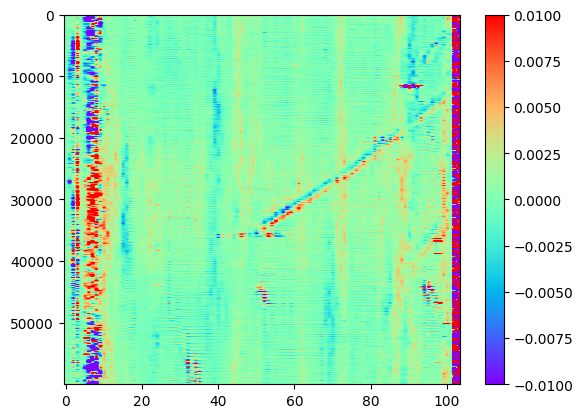

In [73]:
scale = 0.01
im = plt.imshow(data, cmap='rainbow', aspect='auto', vmin=-scale, vmax=scale)
plt.colorbar(im)
plt.show()

In [88]:
# * 将数组中的所有元素取绝对值，确保所有的元素都为正数。
data = abs(np.array(data[:, 10:100]))

In [89]:
data.min(), data.max()

(4.862538e-09, 7.9285436)

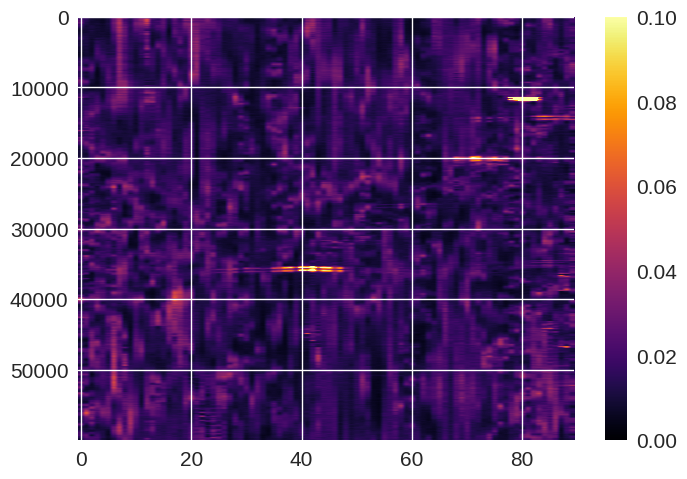

In [90]:
scale = 0.1
im = plt.imshow(data, cmap='inferno', aspect='auto', vmin=0, vmax=scale)
plt.colorbar(im)
plt.show()

In [78]:
# 将数组 data 中的所有零值替换为1，并将所有元素取绝对值以确保它们都为正数。
# data[np.where(data==0)] = 1

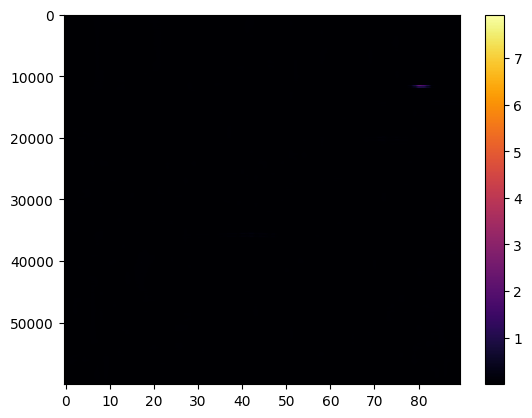

In [79]:
scale = 0.05
im = plt.imshow(data, cmap='inferno', aspect='auto')
plt.colorbar(im)
plt.show()

In [80]:
data.min()

4.862538e-09

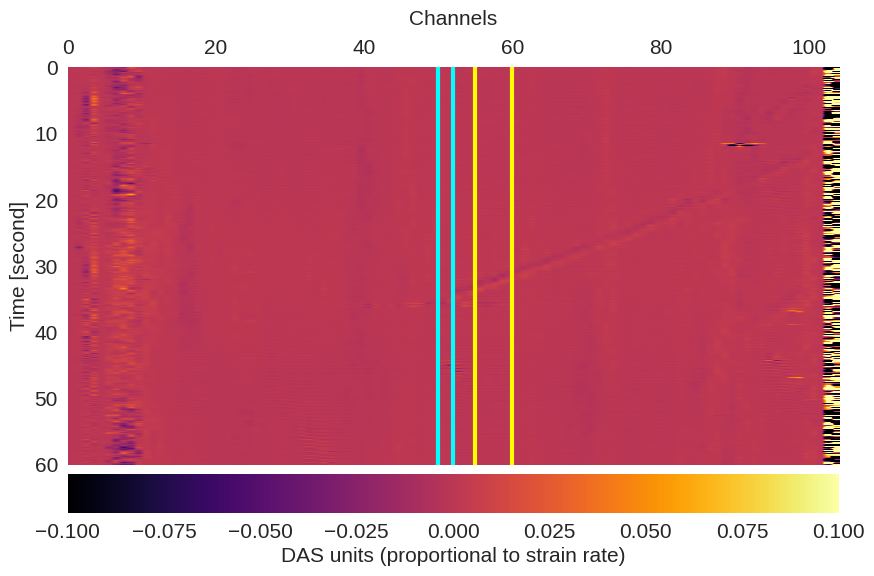

In [96]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# plt.style.use('seaborn')
plt.rc('font', size=15)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

scale = 0.1
fig,ax = plt.subplots(figsize=(9,6))
ax.grid(False)
plt.imshow(data, cmap='inferno',aspect='auto',extent=[0, data.shape[1], data.shape[0]/1_000, 0], vmin=-scale, vmax=scale)#,norm=LogNorm())
ax.axvline(50,color='cyan',lw=3)
ax.axvline(52,color='cyan',lw=3)
ax.axvline(55,color='yellow',lw=3)
ax.axvline(60,color='yellow',lw=3)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xlabel('Channels',labelpad=10)
plt.ylabel('Time [second]')
plt.colorbar(pad=0.02,orientation="horizontal").set_label('DAS units (proportional to strain rate)')
plt.tight_layout()
# plt.savefig('abs_data.png')
plt.show()
plt.close()

In [99]:
data = data.T

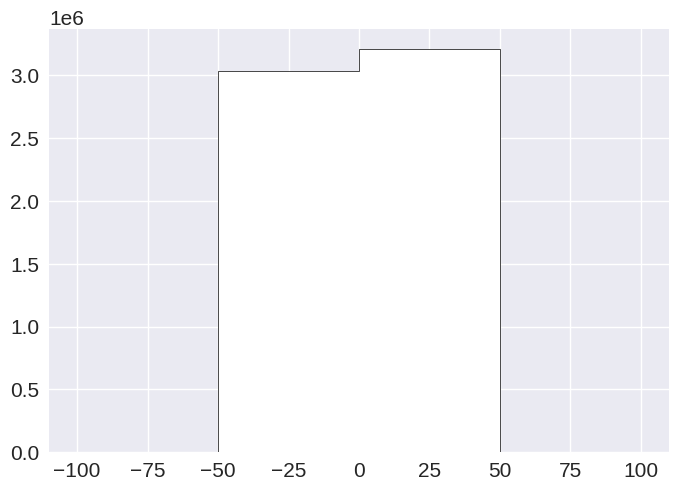

In [108]:
hist = plt.hist(data.reshape(np.prod(data.shape)),bins=4,range=[-100,100],color='white',histtype='stepfilled',edgecolor='black',lw=0.5)
# Fit double gaussian
x = np.array([0.5 * (hist[1][i] + hist[1][i+1]) for i in range(len(hist[1])-1)])
y = hist[0]

In [109]:
x, y, chisq, aic, popt = gaussian_fit(x,y,1)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [ ]:
import matplotlib.pyplot as plt
from mldas.utils import gaussian_fit

fig,ax = plt.subplots(2,1,figsize=(9,8),sharey=True,sharex=True)
for i,order in enumerate([1,2]):
    hist = ax[i].hist(data.reshape(np.prod(data.shape)),bins=40,range=[-100,100],color='white',histtype='stepfilled',edgecolor='black',lw=0.5)
    # Fit double gaussian
    x = np.array([0.5 * (hist[1][i] + hist[1][i+1]) for i in range(len(hist[1])-1)])
    y = hist[0]
    x, y, chisq, aic, popt = gaussian_fit(x,y,order)
    if order==1:
        ax[i].plot(x, y[0], lw=2,label='Single-gaussian fit\n$\chi^2_\mathrm{red}=$%.1e / $\mathrm{AIC}=%i$\n$\mu=%.2f, \sigma=%.3f$'%(chisq,aic,popt[1],abs(popt[2])))
    if order==2:
        ax[i].plot(x, y[0], lw=2,label='Double-gaussian fit\n$\chi^2_\mathrm{red}=$%.1e / $\mathrm{AIC}=%i$'%(chisq,aic))
        # Plot first gaussian
        # y = gauss_single(x, *popt[:3])
        ax[i].plot(x, y[1], lw=2,label=r'$\mu=%.2f, \sigma=%.3f$'%(popt[1],abs(popt[2])))
        # Plot second gaussian
        # y = gauss_single(x, *popt[3:])
        ax[i].plot(x, y[2], lw=2,label=r'$\mu=%.2f, \sigma=%.3f$'%(popt[4],abs(popt[5])))
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].set_xlim(-1000,1000)
    ax[i].legend(loc='upper left')
    ax[i].set_ylabel('Density')
plt.xlabel('Raw measurement amplitude')
plt.tight_layout()
# plt.savefig('distribution.pdf')

Text(0.5, 0, 'Frequency (Hz)')

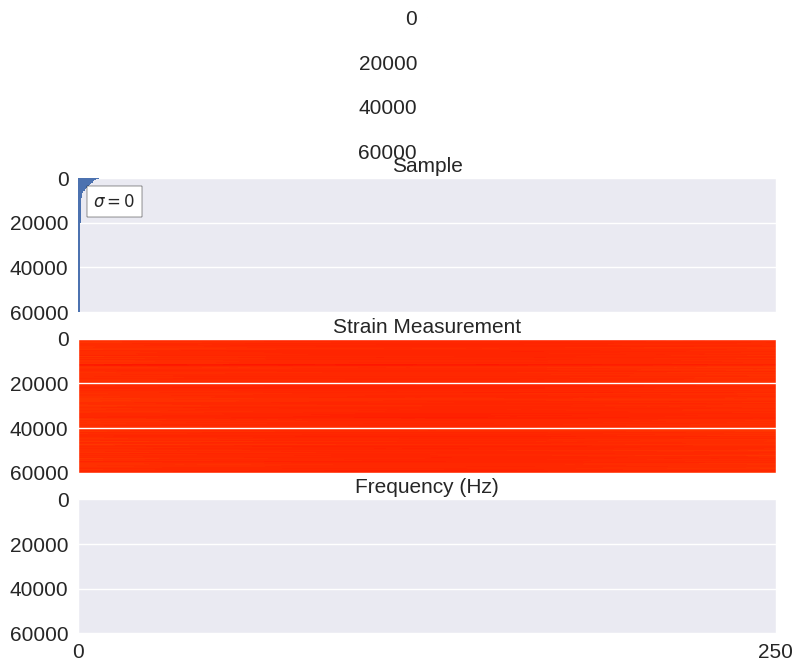

In [117]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.offsetbox import AnchoredText
from mldas.utils import freq_content

img = data.T

fig, ax = plt.subplots(4,1,figsize=(9,8),sharey=True,sharex=True)
ffts, freqs, avg_fft = freq_content(img,img_size=90,sample_rate=1000)
img_max = abs(img).max()
# Show larger image
ax[0].imshow(img,cmap='seismic',extent=[0,200,200,0],vmin=-img_max,vmax=img_max,interpolation='bicubic')
ax[0].set_xlabel('Sample')

# Plotting data distribution
ax[1].hist(img.reshape(np.prod(img.shape)),bins=50)
at = AnchoredText('$\sigma=%i$'%np.std(img),prop=dict(size=12),loc='upper left')
ax[1].add_artist(at)
ax[1].set_xlabel('Strain Measurement')

# D2 and plot FFT for each channel
ax[2].imshow(ffts,extent=[0,500//2,img.shape[0],0],aspect='auto',norm=LogNorm(vmin=ffts.min(),vmax=ffts.max()),cmap='jet')
ax[2].set_xlabel('Frequency (Hz)')

# # Plot average amplitude for each frequency
# ax[3].plot(freqs,avg_fft)
# ax[3].set_xlabel('Frequency (Hz)')
# ax[3].set_xlim(0,500//2)
# ax[3].axvline(40,ls='--',color='black',lw=1.3)
# ax[3].set_ylabel('Average Spectral Amplitude')

In [ ]:
# Better Comments

#* 111

#! 222

# ? 333

# TODO 444

# // 555

# BUG
# HACK
# FIXME
# TODO
# XXX
# [ ]
# [x]
# TAG

## 

### 


In [ ]:
import matplotlib.pyplot as plt
from mldas.utils import gaussian_fit
fig,ax = plt.subplots(2,1,figsize=(9,8),sharey=True,sharex=True)
for i,order in enumerate([1,2]):
    hist = ax[i].hist(data.reshape(numpy.prod(data.shape)),bins=400,range=[-1000,1000],color='white',histtype='stepfilled',edgecolor='black',lw=0.5)
    # Fit double gaussian
    x = numpy.array([0.5 * (hist[1][i] + hist[1][i+1]) for i in range(len(hist[1])-1)])
    y = hist[0]
    x, y, chisq, aic, popt = gaussian_fit(x,y,order)
    if order==1:
        ax[i].plot(x, y[0], lw=2,label='Single-gaussian fit\n$\chi^2_\mathrm{red}=$%.1e / $\mathrm{AIC}=%i$\n$\mu=%.2f, \sigma=%.3f$'%(chisq,aic,popt[1],abs(popt[2])))
    if order==2:
        ax[i].plot(x, y[0], lw=2,label='Double-gaussian fit\n$\chi^2_\mathrm{red}=$%.1e / $\mathrm{AIC}=%i$'%(chisq,aic))
        # Plot first gaussian
        # y = gauss_single(x, *popt[:3])
        ax[i].plot(x, y[1], lw=2,label=r'$\mu=%.2f, \sigma=%.3f$'%(popt[1],abs(popt[2])))
        # Plot second gaussian
        # y = gauss_single(x, *popt[3:])
        ax[i].plot(x, y[2], lw=2,label=r'$\mu=%.2f, \sigma=%.3f$'%(popt[4],abs(popt[5])))
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].set_xlim(-1000,1000)
    ax[i].legend(loc='upper left')
    ax[i].set_ylabel('Density')
plt.xlabel('Raw measurement amplitude')
plt.tight_layout()
plt.savefig('distribution.pdf')